In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# Задание 1
## PAM

In [2]:
def PAM(data, dist = 'euclidean', k = 5):
    """K-Means clustering
    
    Read more in the :ref:`User Guide <k_means>`.
    
    Parameters
    ----------
    data : array-like or sparse matrix, shape=(n_samples, n_features)
        Data as dataframe or matrix
        
    dist : str, optional, default: 'euclidean'
        The metric to use when calculating distance between instances
        
    k : int, optional, default: 5
        The number of clusters to form as well as the number of
        centroids to generate.
        
    Returns
    -------
    inertia : float
        Final value of the objective function
        
    medoids : array
        Indices of data points that are centers
    
    labels : array
        Labels of each data point

    Examples
    --------
    >>> import numpy as np
    >>> X = np.array([[0,1],[2,1],[2,2],
    ...               [8,7],[10,11],[9,12],
    ...               [300,190],[100,587],[365,412]])
    >>> inertia, medoids, labels = PAM(X,  k=3)
    >>> inertia
    557.77536418420073
    >>> medoids
    array([8, 4, 1])
    >>> labels
    array([ 2.,  2.,  2.,  1.,  1.,  1.,  0.,  0.,  0.])
        
    Notes
    ------
    The function can raise exceptions from dependent functions 
    like pdist(), np.array()
    
    1) Convert given data to np.array
    2) Select random medoids
    3) Assignment: assign each data point ot the closest medoid
    With cdist we find distances and then set label for each data point 
    4) Update: find new medoid in each cluster, that will give the 
    lowest value of the objective function. 
    (i.e. we replace each medoid with data from its cluster and count 
    value of the objective function, if it lower than previous, we save medoid,
    else we replace back)
    5) Do 3 and 4 steps, while there is changes
    """
    # Objective function
    def cost_configuration(data, medoids, labels):
        cost = 0
        for dtp in range(data.shape[0]):
            cost += pdist([data[dtp], data[medoids[int(labels[dtp])]]], dist)[0]

        return cost
    
    if k < 1:
        raise ValueError("Amount of clusters cannot be less than 1")
        
    inertia = 0 # Value of the objective function
    
    # Convert to np.array
    data_np = np.array(data, dtype = np.float64)
    
    if k > data_np.shape[0]:
        raise ValueError("Amount of clusters cannot be more than number of data points")
    
    # Label of each data point 
    labels = np.zeros(shape=(data_np.shape[0])) 
    
    # Coordinates of cluster centers cluster_centers_ 
    medoids = np.zeros(k, dtype=int)
    
    # Select random medoids
    random_medoids = random.sample(range(data_np.shape[0]), k)
    for i in range(len(random_medoids)):
        medoids[i] = random_medoids[i]
 
    # Copy medoids
    old_medoids = np.copy(medoids)
    
    while True:
        
        # Assignment
        cd = cdist(data_np, data_np[medoids], dist)
        for i in range(cd.shape[0]):
            labels[i] = cd[i].argmin()
        
        # Update
        costs = cost_configuration(data_np, medoids, labels)
        
        # For each medoid
        for clust_cent in range(medoids.shape[0]):
            # For each datapoint
            for dtp in range(data_np.shape[0]):
                if labels[dtp] != clust_cent:
                    continue
                
                # Select new medoid
                old_medoid = np.copy(medoids[clust_cent])
                medoids[clust_cent] = np.copy(dtp)

                # count value of objective function
                new_costs = cost_configuration(data_np, medoids, labels)
                
                # If new value is higher previous, return back
                if new_costs > costs:
                    medoids[clust_cent] = np.copy(old_medoid)
                else:
                    costs = new_costs
                    
        inertia = costs
        
        if np.array_equal(old_medoids,medoids):
            break;
        
        old_medoids = np.copy(medoids)
        
    return inertia, medoids, labels

### Решения для оптимизации
1. Вместо `pdist([data_norm[dtp], medoids[int(labels[dtp])]], dist)`, который сравнивал два объекта из ndarray, воспользовался `cdist(data_norm,medoids, dist)`, который автоматически попарно сравнивает и работает чисто с np.array => оптимизирует

# Задание 2

In [3]:
data = pd.read_csv('minor_iad_3_6.csv')
data.head()

,Length,Width,Thickness,Working Width,Epoch
0,16.483075,2.111464,1.938214,2.170250,8.458909
1,10.079790,4.105508,1.177260,3.795268,10.125621
2,10.431195,4.062636,0.925016,3.956945,4.994397
3,7.031624,6.173499,2.263253,1.288572,4.792958
4,8.515158,3.651649,0.975398,3.801612,4.105251


In [4]:
# приведение к единичной Евклидовой норме
data_norm = pd.DataFrame(preprocessing.normalize(data, norm="l2"), 
                         columns=data.columns)
data_norm.head()

,Length,Width,Thickness,Working Width,Epoch
0,0.873393,0.111881,0.102701,0.114996,0.448214
1,0.655063,0.266808,0.076507,0.246646,0.658041
2,0.807742,0.314591,0.071629,0.306407,0.386742
3,0.649212,0.569983,0.208960,0.118971,0.442521
4,0.783555,0.336020,0.089755,0.349820,0.377760


Уменьшаем размерность для того, чтобы мы могли отобразить наши данные.

In [5]:
tsne = TSNE(random_state=17)
data_tsne = tsne.fit_transform(data)

pca = PCA(2)
data_pca = pca.fit_transform(data)

Функции для дальнейшего представления наших данных.

In [6]:
def plot_tsne(labels = None):
    plt.figure(figsize=(12,10))
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c = labels,
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    
    if (labels is not None):
        plt.colorbar()
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.title('MNIST. t-SNE projection')
    plt.show()

def plot_pca(labels = None):
    plt.figure(figsize=(12,8))
    plt.scatter(data_pca[:,0], data_pca[:,1], c=labels)
    plt.title('PCA')
    plt.plot()
    plt.show()

Посмотрим на графическое представление данных:

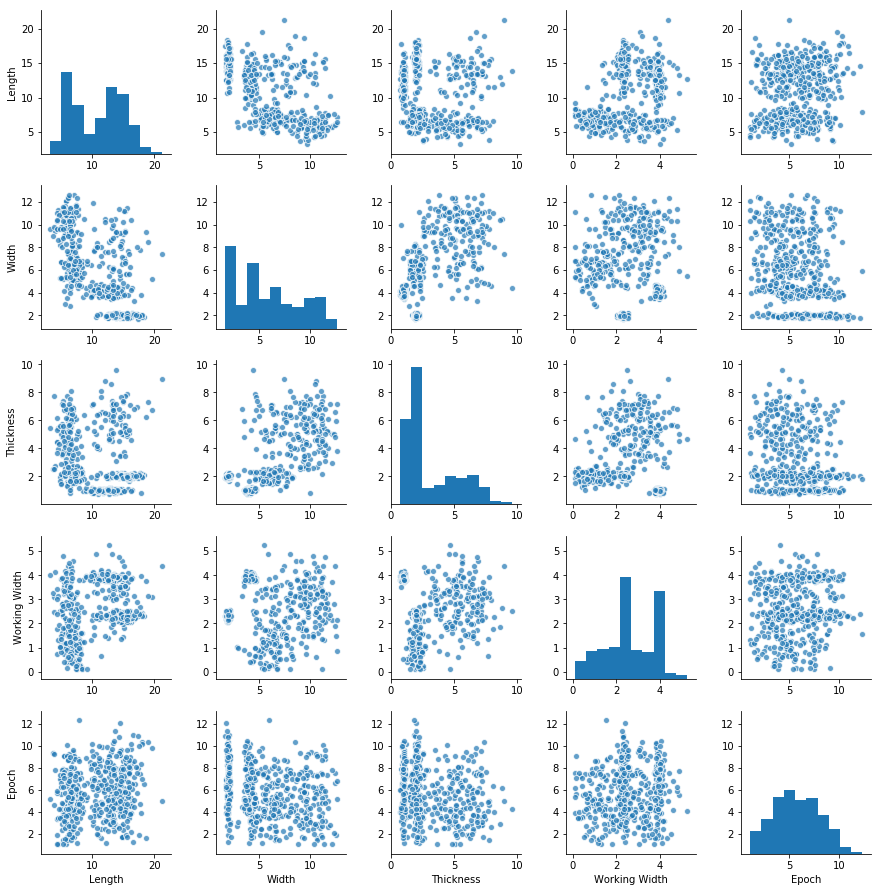

In [16]:
sns.pairplot(data, 
             plot_kws={'alpha':0.7}
            )
plt.show()

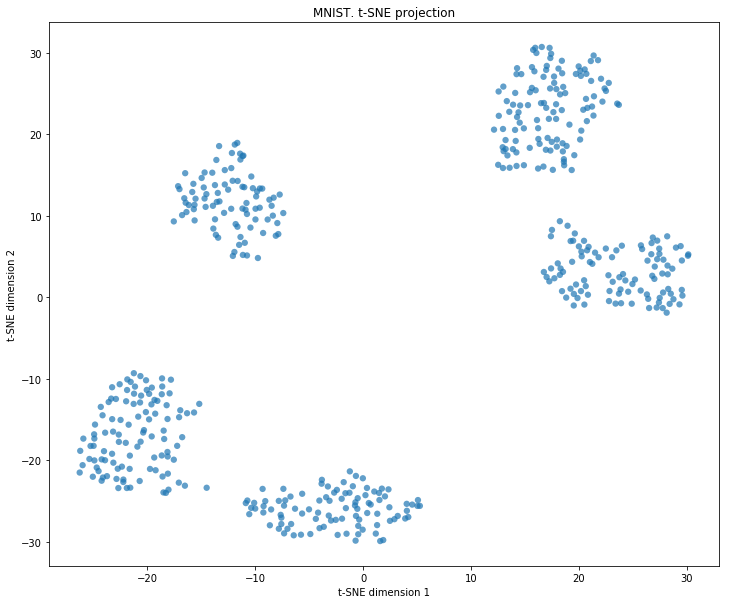

In [17]:
plot_tsne()

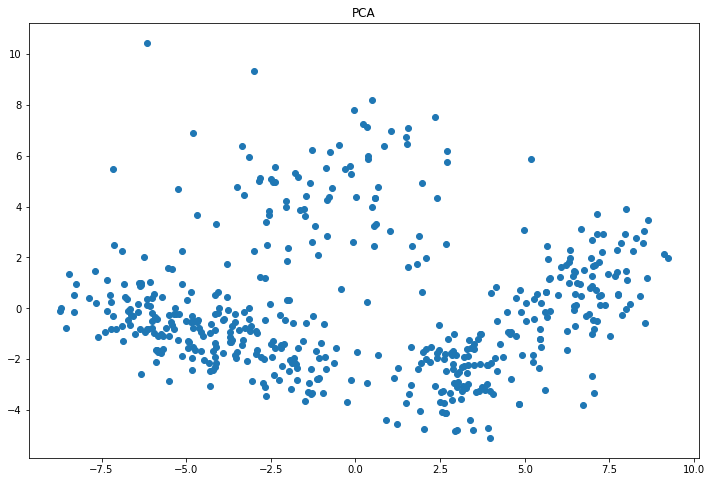

In [18]:
plot_pca()

## Задание 2.1
## Hierarchy clustering

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Картинка красивая, но на ней сложно что-либо понять, поэтому метод single нам не подходит.

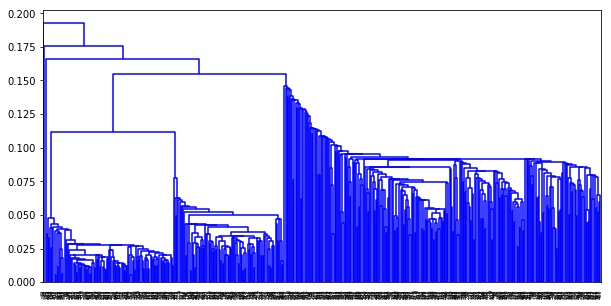

In [20]:
Z = linkage(data_norm, metric='euclidean', method = 'single')

plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0)
plt.show()

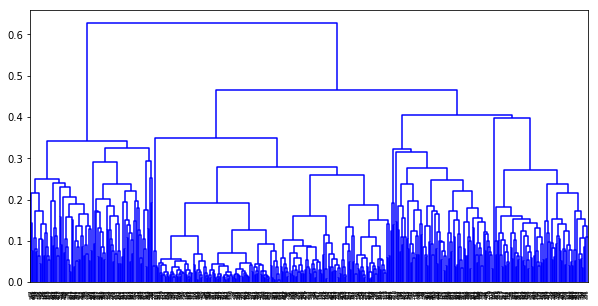

In [21]:
Z = linkage(data_norm, metric='euclidean', method = 'average')

plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0)
plt.show()

Метод complete подходит лучше всего.

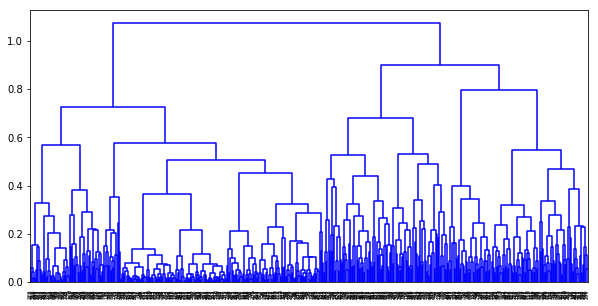

In [22]:
Z = linkage(data_norm, metric='euclidean', method = 'complete')

plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0)
plt.show()

### Попробуем разные расстояния

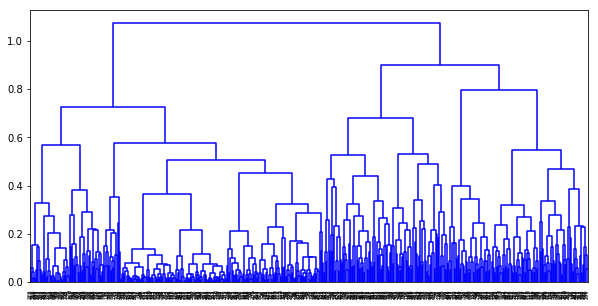

In [23]:
Z = linkage(data_norm, metric='minkowski', method = 'complete')

plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0)
plt.show()

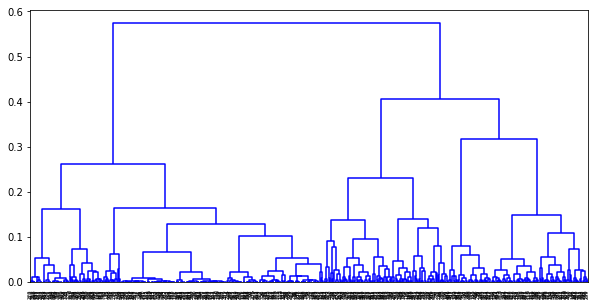

In [70]:
Z = linkage(data_norm, metric='cosine', method = 'complete')

plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0)
plt.show()

Данные расстояния показывают примерно одинаковый результат.

Наилучшим сочетанием, на мой взгляд, оказалось: `metric='cosine', method = 'complete'`.

Теперь посмотрим, где нам стоит определить порог расстояния. 

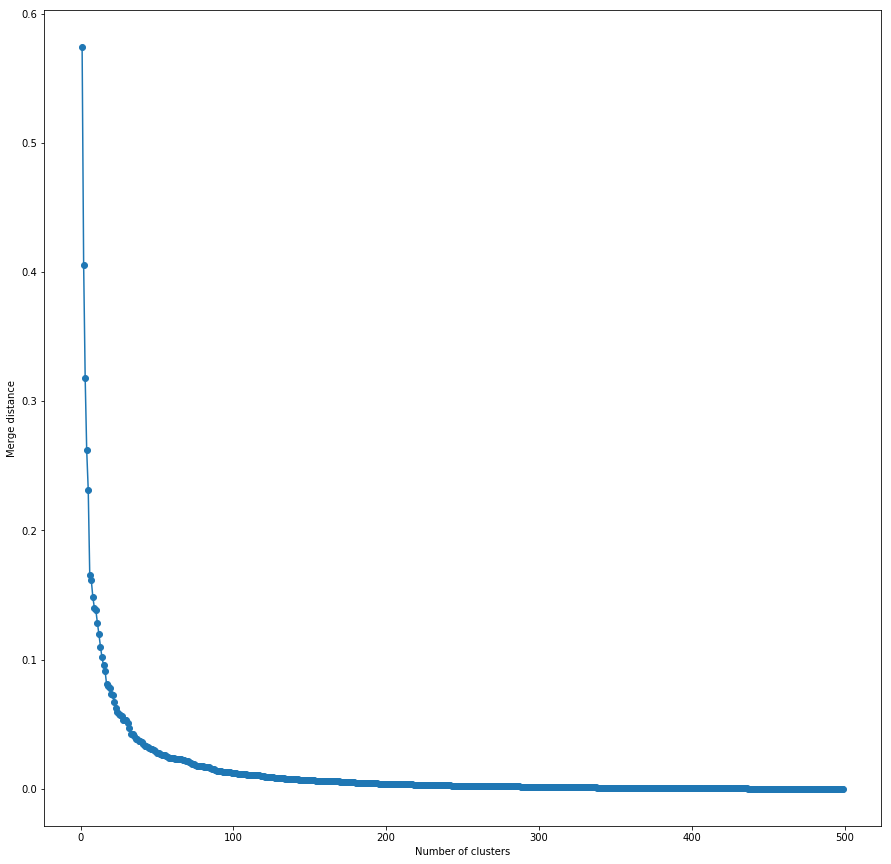

In [25]:
def plot_elbow(Z, h=15, w=15):
    plt.figure(figsize=(h, w))
    plt.plot(np.array(range(1, np.shape(Z)[0]+1)), 
             Z[:,2][::-1], 
             marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Merge distance")
    plt.show()
plot_elbow(Z)

Если выбирать количество кластеров по локтевому методу, то получается достаточно много кластеров..

Возьмем для примера количество кластеров, равное 6.

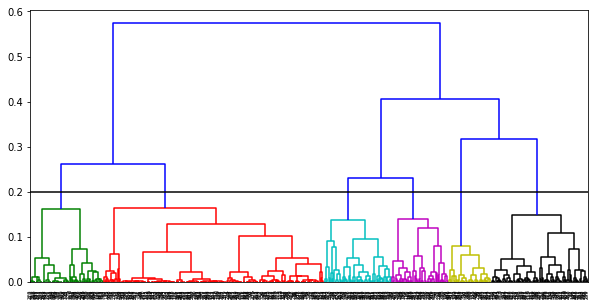

In [64]:
plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0.2)
plt.axhline(y=0.2, c='k')
plt.show()

Достанем labels

In [65]:
labels_hier = fcluster(Z, t = 6, criterion='maxclust')

Посмотрим на то, как кластеры выглядят в графическом представлении.

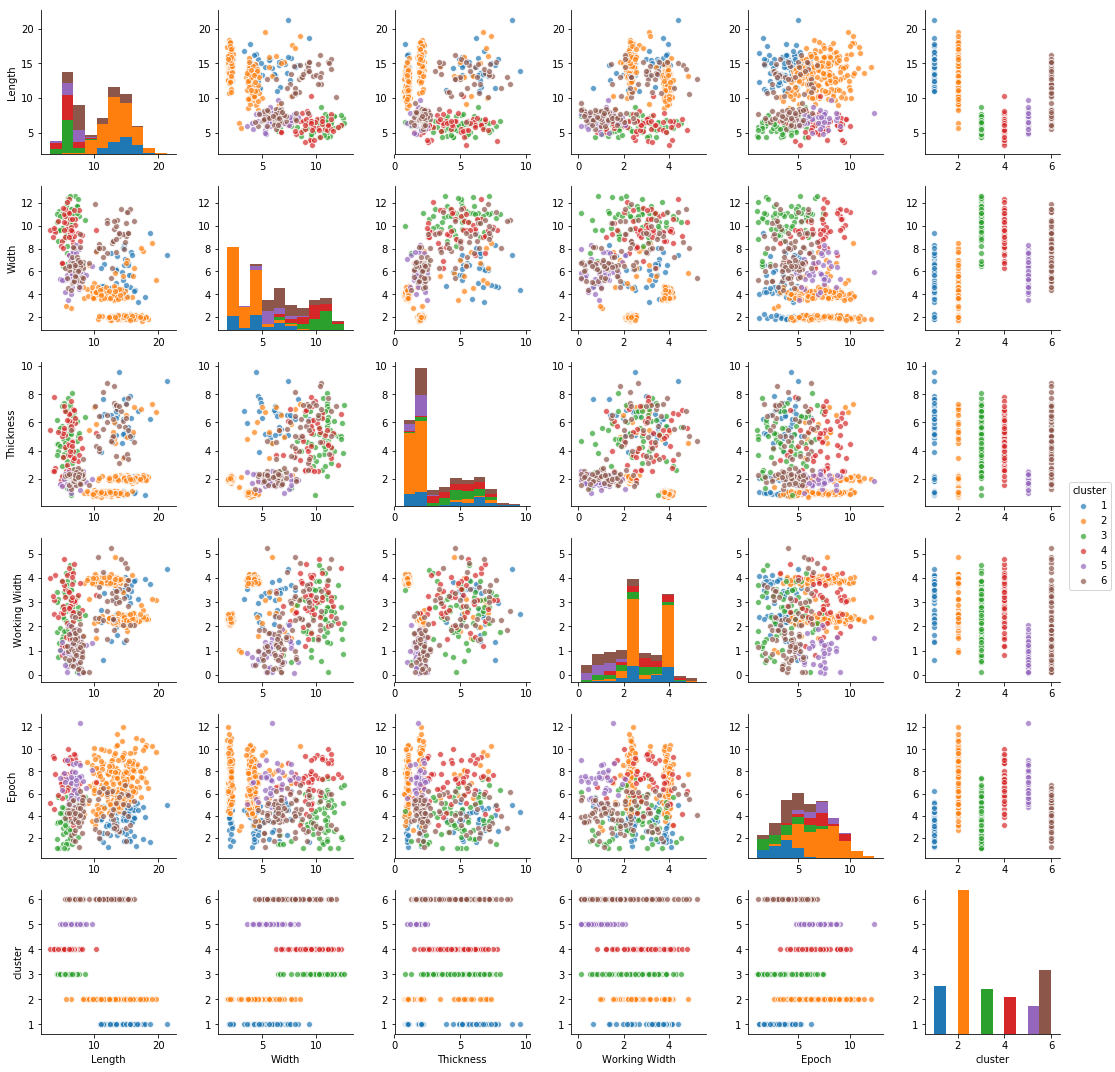

In [77]:
data['cluster'] = labels_hier
sns.pairplot(data, hue='cluster', plot_kws={'alpha':0.7})
plt.show()

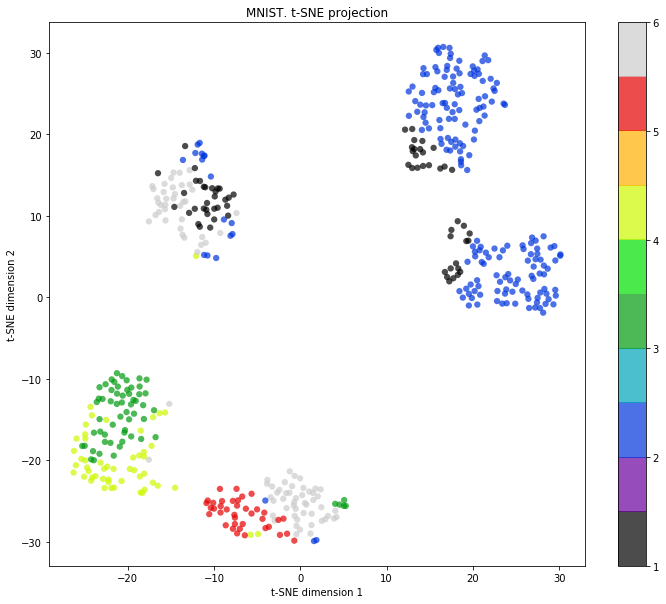

In [68]:
plot_tsne(labels_hier)

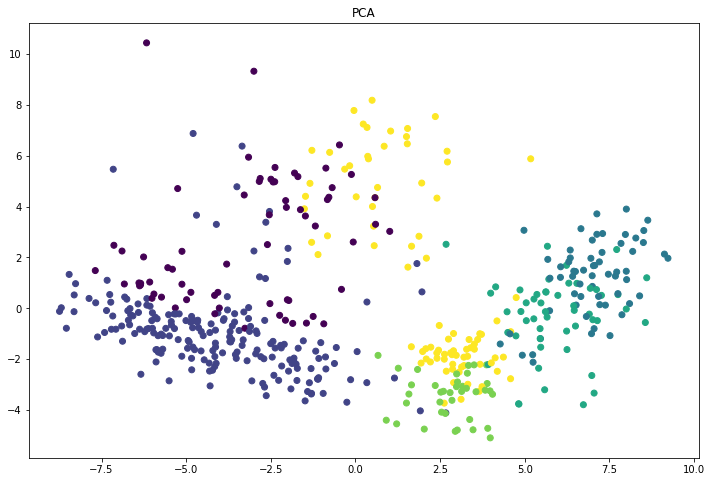

In [69]:
plot_pca(labels_hier)

## Задание 2.2
## DBSCAN

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

min_samp = 5

Подберем `eps` и `min_samples`.

`min_samples` = dimension.

`eps` найдем с помощью `sklearn.neighbors.NearestNeighbors` и k-distance graph.

### metric = cityblock

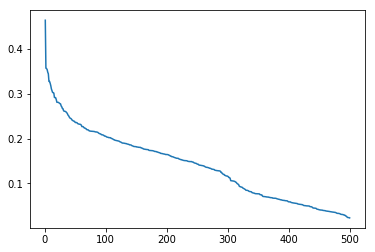

In [32]:
neigh = NearestNeighbors(n_neighbors=min_samp, metric='cityblock').fit(data_norm)
distances, indices = neigh.kneighbors(data_norm)

distanceDec = sorted(distances[:,min_samp-1], reverse=True)

plt.plot(list(range(1,data_norm.shape[0]+1)), distanceDec)
plt.show()

In [33]:
dbscan = DBSCAN(eps=0.2, min_samples=5, metric='cityblock')

dbscan.fit(data_norm)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='cityblock',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

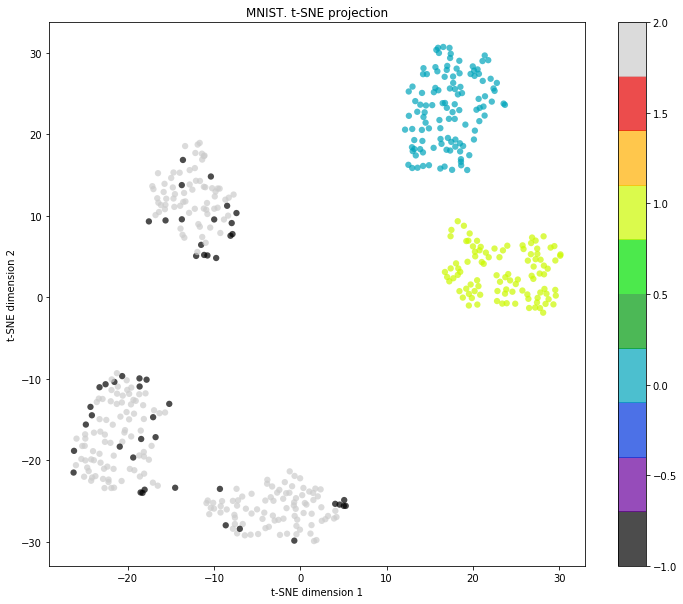

In [34]:
plot_tsne(dbscan.labels_)

### metric = cosine

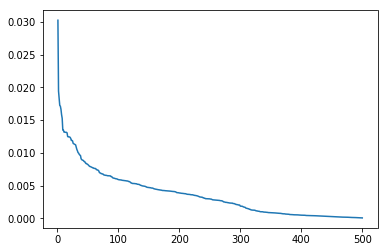

In [35]:
neigh = NearestNeighbors(n_neighbors=min_samp, metric='cosine').fit(data_norm)
distances, indices = neigh.kneighbors(data_norm)

distanceDec = sorted(distances[:,min_samp-1], reverse=True)

plt.plot(list(range(1,data_norm.shape[0]+1)), distanceDec)
plt.show()

In [36]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')

dbscan.fit(data_norm)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

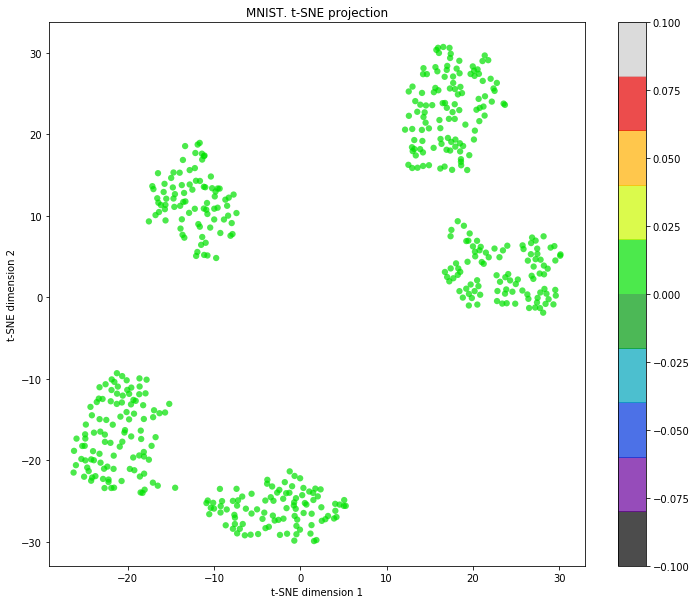

In [37]:
plot_tsne(dbscan.labels_)

### metric = euclidean
Остановимся на этой метрике

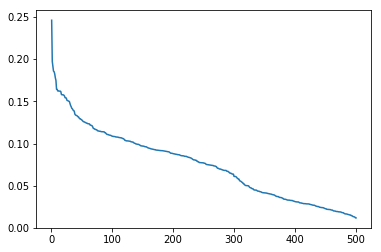

In [38]:
neigh = NearestNeighbors(n_neighbors=min_samp, metric='euclidean').fit(data_norm)
distances, indices = neigh.kneighbors(data_norm)

distanceDec = sorted(distances[:,min_samp-1], reverse=True)

plt.plot(list(range(1,data_norm.shape[0]+1)), distanceDec)
plt.show()

In [39]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric='euclidean')

dbscan.fit(data_norm)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Отобразим наши кластеры

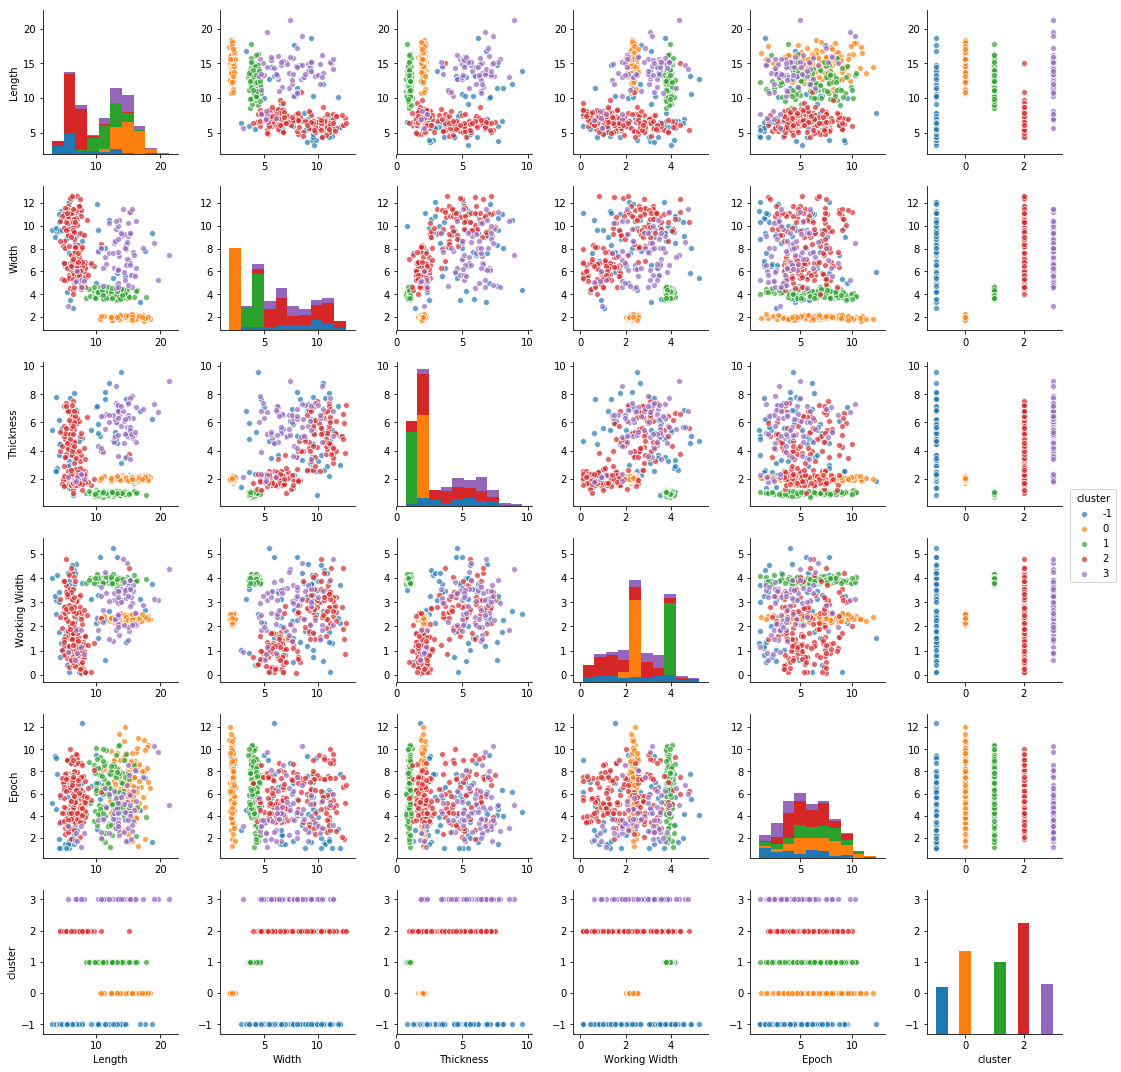

In [74]:
data['cluster'] = dbscan.labels_
sns.pairplot(data, hue='cluster', plot_kws={'alpha':0.7})
plt.show()

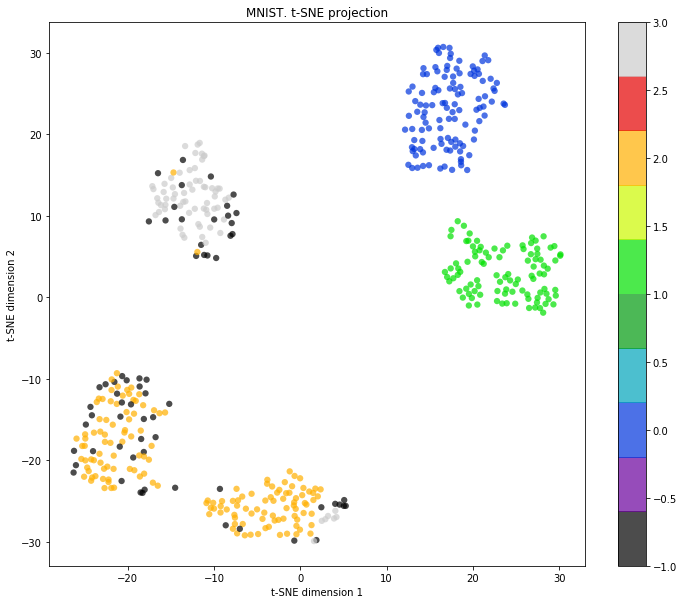

In [41]:
plot_tsne(dbscan.labels_)

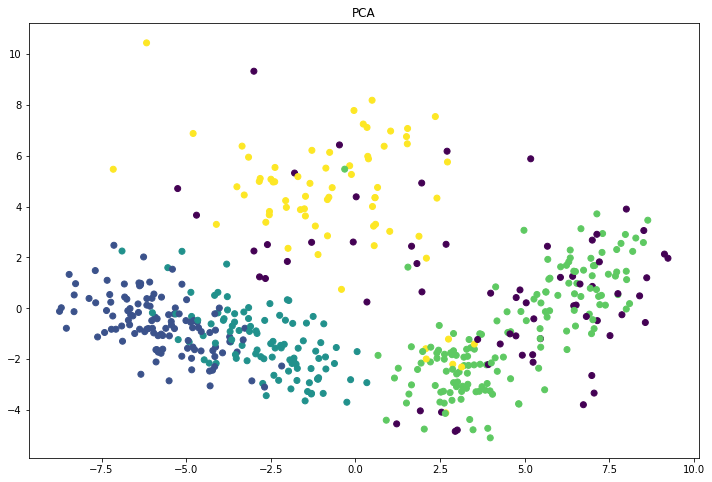

In [42]:
plot_pca(dbscan.labels_)

## Задание 2.3
## K-Means

In [8]:
from sklearn.cluster import KMeans

Выберем наилучшее количество кластеров.

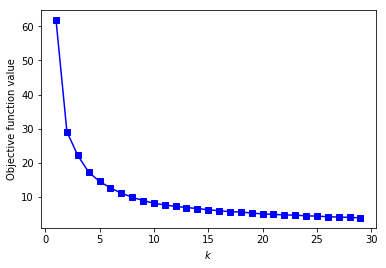

In [44]:
inertia = []
end = 30
for k in range(1, end):
    Z = KMeans(n_clusters=k, 
               init = 'random',
               n_init = 100,
               max_iter = 1000,
               random_state=2).fit(data_norm)
    inertia.append(Z.inertia_)

plt.plot(range(1, end), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.show()

На мой взгляд, наилучшее количество = 5

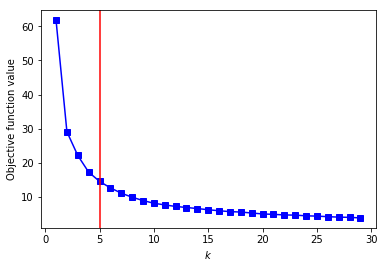

In [45]:
plt.plot(range(1, end), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.axvline(x=5, c='r')
plt.show()

In [9]:
kmeans = KMeans(n_clusters = 5,
           init = 'random',
           n_init = 1,
           max_iter = 1000, 
           random_state=2,
          )
kmeans.fit(data_norm)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

Отобразим наши кластеры

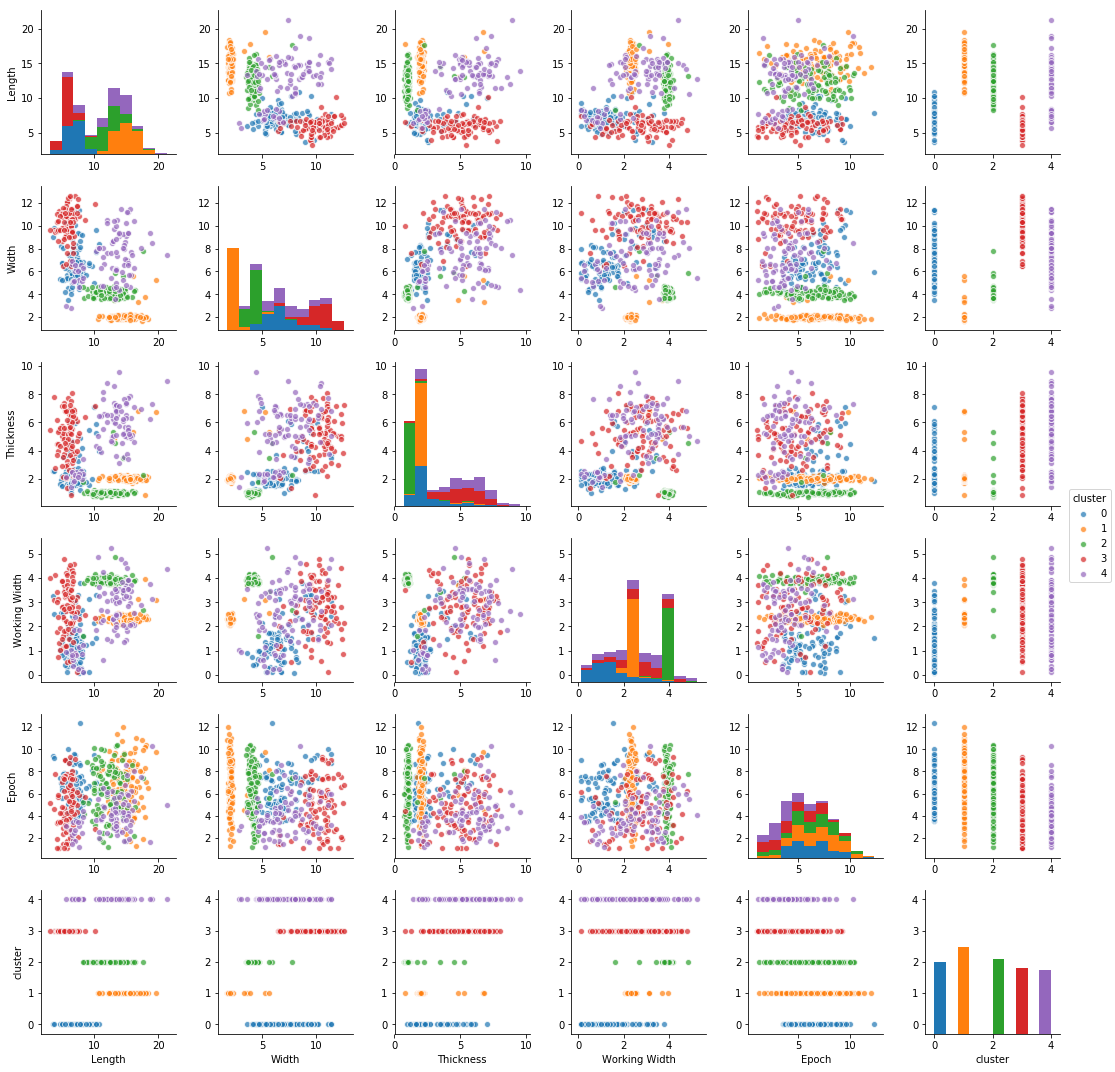

In [47]:
data['cluster'] = kmeans.labels_
sns.pairplot(data, hue='cluster', plot_kws={'alpha':0.7})
plt.show()

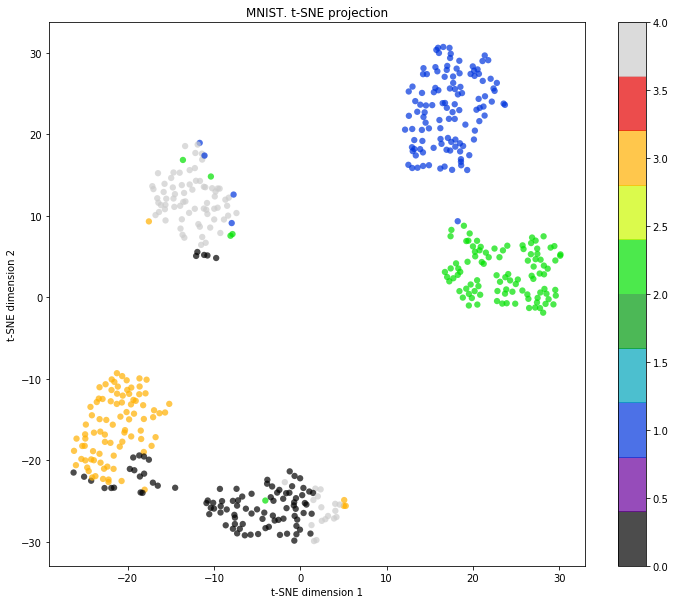

In [48]:
plot_tsne(kmeans.labels_)

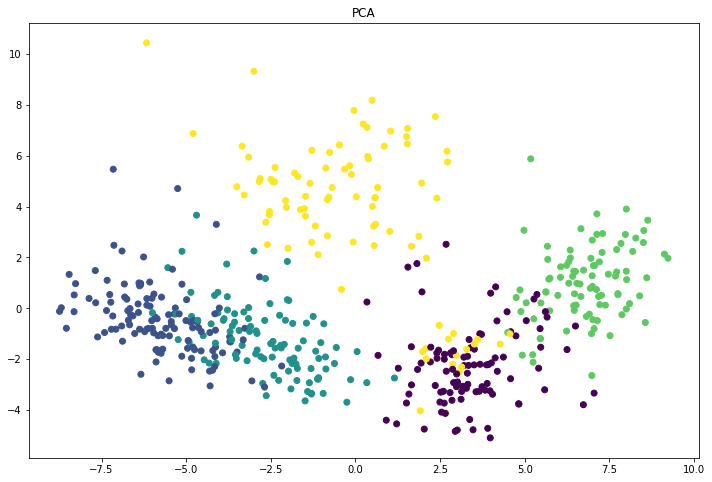

In [51]:
plot_pca(kmeans.labels_)

## Задание 2.4
## PAM

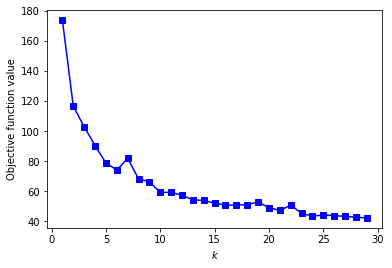

In [79]:
inertia = []
end = 30
for cl in range(1, end):
    i,m,l = PAM(data_norm, k = cl)
    inertia.append(i)

plt.plot(range(1, end), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.show()

Возьмем количество кластеров, равное 5.

### dist='cityblock'

Inert:
 138.837419826


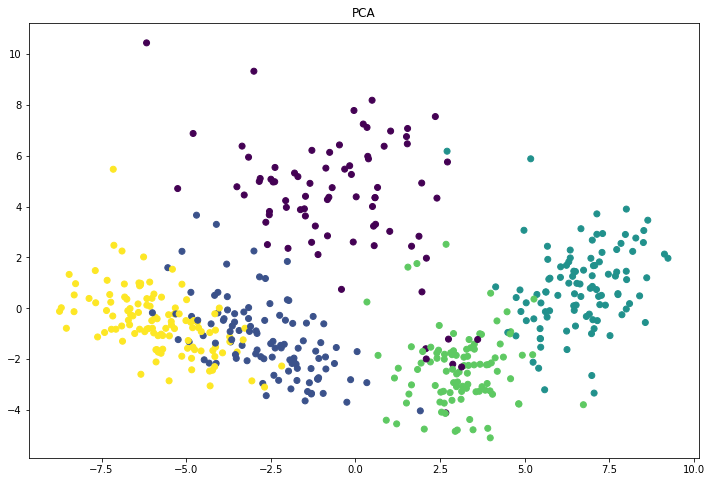

In [80]:
inertia, medoids, labels_pam = PAM(data_norm, dist='cityblock',k=5)
print('Inert:\n', inertia)
plot_pca(labels_pam)

### dist='euclidean'
Остановимся на этом расстоянии.

Inert:
 78.761715202


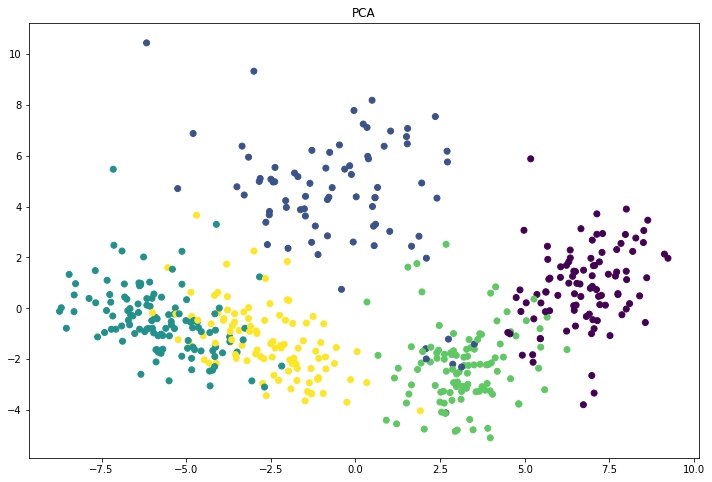

In [81]:
inertia, medoids, labels_pam = PAM(data_norm, k=5)
print('Inert:\n', inertia)
plot_pca(labels_pam)

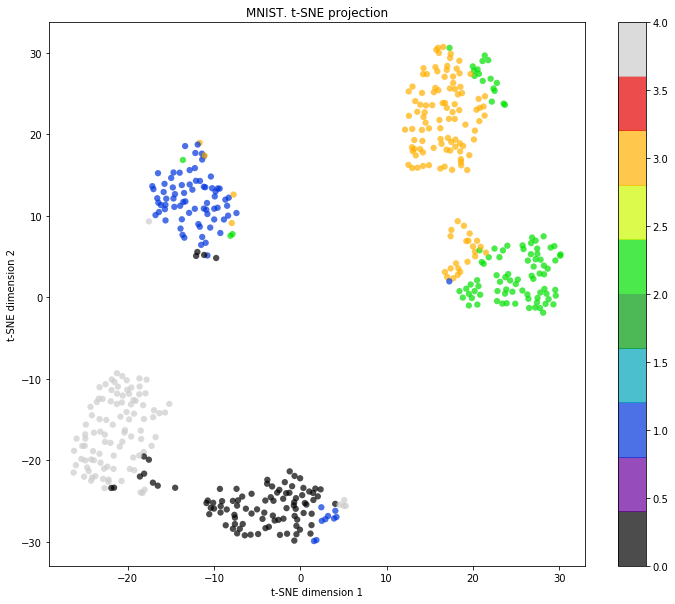

In [56]:
plot_tsne(labels_pam)

## Задание 2.5
## Сравнение разбиений
В итоге мы получили следующие 4 разбиения:

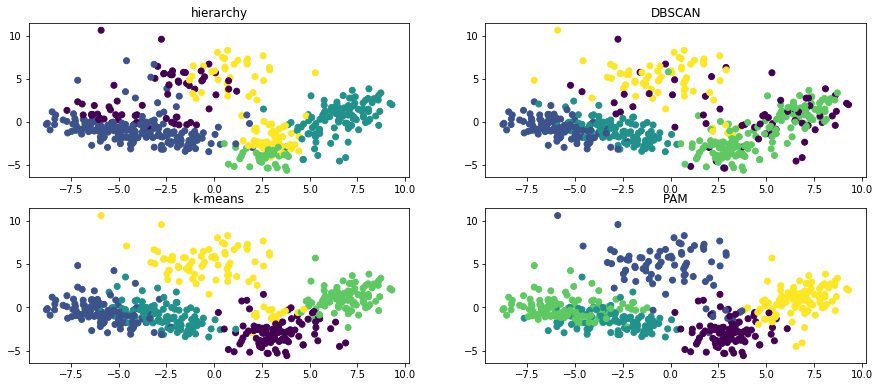

In [57]:
pca = PCA(2)
res = pca.fit_transform(data)

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(6.25)

hier_fig = fig.add_subplot(221)
hier_fig.scatter(res[:,0], res[:,1], c=labels_hier)
hier_fig.set_title('hierarchy')

dbscan_fig = fig.add_subplot(222)
dbscan_fig.scatter(res[:,0], res[:,1], c=dbscan.labels_)
dbscan_fig.set_title('DBSCAN')

kmeans_fig = fig.add_subplot(223)
kmeans_fig.scatter(res[:,0], res[:,1], c=kmeans.labels_)
kmeans_fig.set_title('k-means')

pam_fig = fig.add_subplot(224)
pam_fig.scatter(res[:,0], res[:,1], c=labels_pam)
pam_fig.set_title('PAM')

plt.show()

#### Metrics

In [58]:
from sklearn.metrics import calinski_harabaz_score, silhouette_score


print("KMEANS")
CH_score = calinski_harabaz_score(data, kmeans.labels_)
S_score = silhouette_score(data, kmeans.labels_)
print("calinski_harabaz_score:",CH_score)
print("silhouette_score:",S_score)

print("HIER")
CH_score = calinski_harabaz_score(data, labels_hier)
S_score = silhouette_score(data, labels_hier)
print("calinski_harabaz_score:",CH_score)
print("silhouette_score:",S_score)

print("DBSCAN")
CH_score = calinski_harabaz_score(data, dbscan.labels_)
S_score = silhouette_score(data, dbscan.labels_)
print("calinski_harabaz_score:",CH_score)
print("silhouette_score:",S_score)

print("PAM")
CH_score = calinski_harabaz_score(data, labels_pam)
S_score = silhouette_score(data, labels_pam)
print("calinski_harabaz_score:",CH_score)
print("silhouette_score:",S_score)

KMEANS
calinski_harabaz_score: 278.538202495
silhouette_score: 0.317714072395
HIER
calinski_harabaz_score: 180.067490859
silhouette_score: 0.197752896966
DBSCAN
calinski_harabaz_score: 174.811635238
silhouette_score: 0.220418156779
PAM
calinski_harabaz_score: 276.250692543
silhouette_score: 0.295478438647


Судя по изображениям и метрикам, наилучшее разбиение получилось у k-means. Кроме того, PAM также показал хороший результат, а вот иерархическая кластеризация показала наихудший результат.

## Задание 2.6
## Интерпретация
Возьмем разбиение, получившееся с помощью k-means.

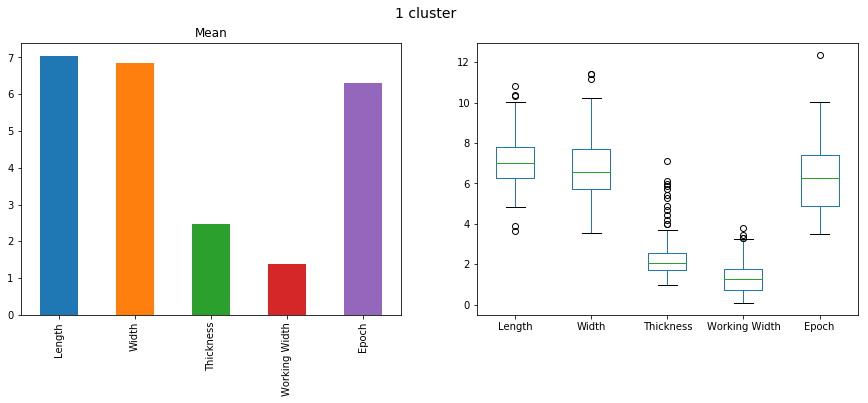

Mean:
Length           7.038798
Width            6.842722
Thickness        2.472673
Working Width    1.392439
Epoch            6.302206
dtype: float64 



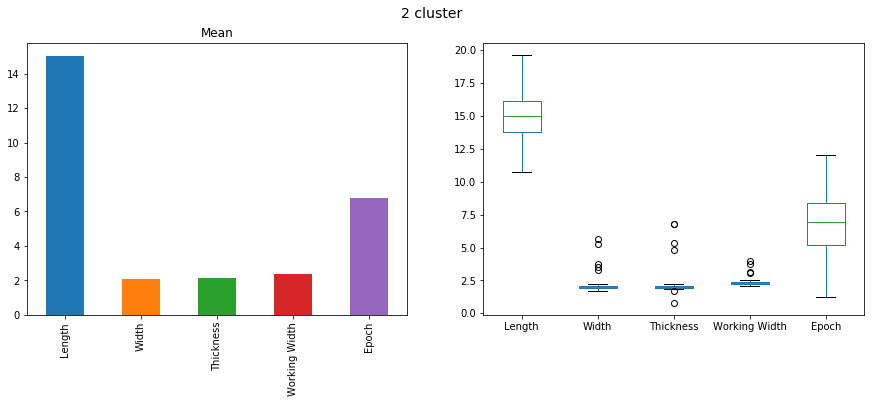

Mean:
Length           15.015144
Width             2.084461
Thickness         2.142169
Working Width     2.347703
Epoch             6.803017
dtype: float64 



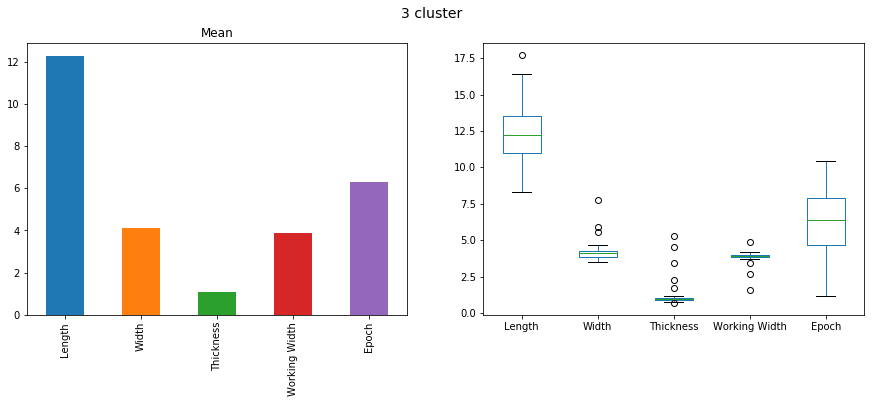

Mean:
Length           12.258492
Width             4.135838
Thickness         1.102720
Working Width     3.887861
Epoch             6.283784
dtype: float64 



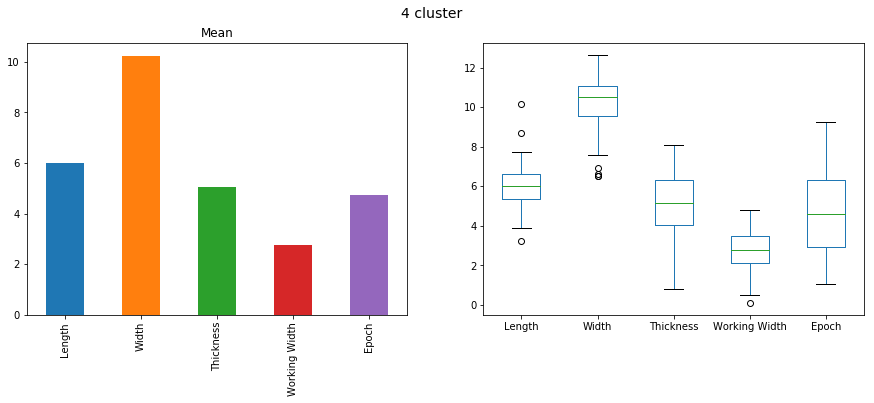

Mean:
Length            5.985263
Width            10.228928
Thickness         5.070582
Working Width     2.749387
Epoch             4.730518
dtype: float64 



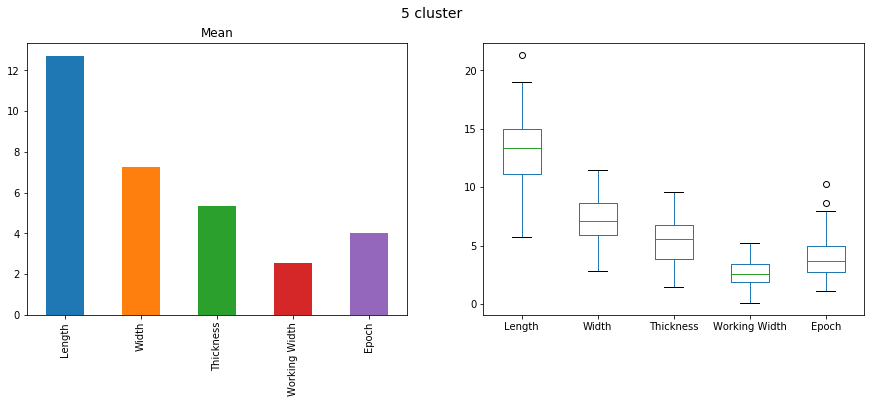

Mean:
Length           12.707510
Width             7.255257
Thickness         5.337574
Working Width     2.571115
Epoch             4.028193
dtype: float64 



In [52]:
for i in range(5):
    idx = np.argwhere(kmeans.labels_ == i)
    clust = data.iloc[idx.flatten()]
    
    fig, axes = plt.subplots(nrows=1,ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    clust.mean().plot.bar(ax=axes[0])
    clust.plot.box(ax=axes[1])
    
    axes[0].set_title('Mean');
    plt.suptitle(str(i+1)+' cluster', fontsize=14)
    plt.show()
    
    print("Mean:")
    print(clust.mean(),'\n')

## Задание 2.7
### Типы орудий

На мой взгляд, **первый** кластер с такими характеристиками - это ручной топор (handaxe):
![handaxe.jpg](handaxe.jpg)

**Второй** кластер — вероятно, это было какое-то подобие лезвия ножа, например: 
![knife_blade.jpg](knife_blade.jpg)

**Третий** тоже похож на нож:
![knife.jpg](knife.jpg)

**Четвертый**, судя по толщине и ширине — скребок (scraper):
![scraper.jpg](scraper.jpg)

А **пятый** может быть камнем для заточки и шлифования:
![grinding_stone.jpg](grinding_stone.jpg)

Все права на фотографии принадлежат: [paleodirect.com](www.paleodirect.com)